# Classifying Bonds as Overpriced or underpriced

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import datetime as dt
import os
import seaborn as sns
import random 
from scipy.optimize import newton
import itertools

In [349]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_theme()
sns.set_palette("tab20")
sns.set_style("darkgrid", rc = {"grid.color": "white"})
c10 = sns.color_palette("tab10").as_hex()[:]
c20 = sns.color_palette("tab20").as_hex()[:]

In [4]:
pd.set_option('display.max_columns', None)
os.chdir('/Users/maris/Documents/FE800')

## Import Data

In [5]:
df = pd.read_pickle("factor_df.pkl")
df = df.drop(["92976GAJ0", "902613AY4", "64110LAT3", "64110LAS5"])
df["Volume"] = df["Volume"].fillna(0)
df["Trades"] = df["Trades"].fillna(0)
df.head()

Price     Volume  Trades    Return       Age  \
cusip     trd_dt                                                      
00206RBH4 2018-07-02  86.132  2643000.0    13.0  0.000000  5.041096   
          2018-07-03  86.821    49000.0     7.0  0.007999  5.043836   
          2018-07-05  86.730   951000.0    24.0 -0.001048  5.049315   
          2018-07-06  88.675   678000.0    11.0  0.022426  5.052055   
          2018-07-09  89.397  2900000.0     7.0  0.008142  5.060274   

                            TTM  Stock_Return  Stock_Volume  ETF_Return  \
cusip     trd_dt                                                          
00206RBH4 2018-07-02  24.471233      0.000000    50002449.0    0.000000   
          2018-07-03  24.468493      0.015523    44857650.0   -0.005025   
          2018-07-05  24.463014     -0.003363    46895286.0    0.004959   
          2018-07-06  24.460274      0.002454    54541518.0    0.007858   
          2018-07-09  24.452055      0.004123    57539848.0    0.011967   

                            PV       YTM   Duration      DV01   Convexity  
cusip     trd_dt                                                           
00206RBH4 2018-07-02       NaN  0.054010  16.324665 -1.406076  339.273017  
          2018-07-03  0.004849  0.053445  16.343155 -1.418929  339.790490  
          2018-07-05  0.001749  0.053541  16.344714 -1.417577  339.812463  
          2018-07-06  0.001668  0.051959  16.349071 -1.449754  339.925850  
          2018-07-09 -0.002931  0.051410  16.326755 -1.459563  339.254704

In [9]:
scaler = StandardScaler()
scaled_volume, scaled_stock_volume = [], []

for i in df.index.droplevel(1).unique():
    scaled_volume.extend(scaler.fit_transform(df.loc[i][["Volume"]]))
    scaled_stock_volume.extend(scaler.fit_transform(df.loc[i][["Stock_Volume"]]))

df["Volume"] =  [item for sublist in scaled_volume for item in sublist]
df["Stock_Volume"] =  [item for sublist in scaled_stock_volume for item in sublist]
df.head()

Price    Volume  Trades    Return       Age        TTM  \
cusip     trd_dt                                                                
00206RBH4 2018-07-02  86.132 -0.169280    13.0  0.000000  5.041096  24.471233   
          2018-07-03  86.821 -0.779797     7.0  0.007999  5.043836  24.468493   
          2018-07-05  86.730 -0.567504    24.0 -0.001048  5.049315  24.463014   
          2018-07-06  88.675 -0.631757    11.0  0.022426  5.052055  24.460274   
          2018-07-09  89.397 -0.108793     7.0  0.008142  5.060274  24.452055   

                      Stock_Return  Stock_Volume  ETF_Return        PV  \
cusip     trd_dt                                                         
00206RBH4 2018-07-02      0.000000      0.043275    0.000000       NaN   
          2018-07-03      0.015523     -0.171355   -0.005025  0.004849   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749   
          2018-07-06      0.002454      0.232636    0.007858  0.001668   
          2018-07-09      0.004123      0.357721    0.011967 -0.002931   

                           YTM   Duration      DV01   Convexity  
cusip     trd_dt                                                 
00206RBH4 2018-07-02  0.054010  16.324665 -1.406076  339.273017  
          2018-07-03  0.053445  16.343155 -1.418929  339.790490  
          2018-07-05  0.053541  16.344714 -1.417577  339.812463  
          2018-07-06  0.051959  16.349071 -1.449754  339.925850  
          2018-07-09  0.051410  16.326755 -1.459563  339.254704

In [10]:
macro_factors = pd.read_pickle("macro_factors.pkl").pct_change()
macro_factors = macro_factors.drop(["EFFR", "Lower_Target", "Upper_Target"], axis = 1)
macro_factors.head()

,1YRT,2YRT,3YRT,5YRT,7YRT,10YRT,30YRT,SPY,LQD
2018-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,-0.004274,-0.015564,-0.007547,-0.010909,-0.014134,-0.013937,-0.010033,-0.003531,0.003677
2018-07-05,-0.004292,0.007905,0.007605,0.007353,0.003584,0.003534,-0.003378,0.008158,0.003140
2018-07-06,0.008621,-0.007843,-0.003774,-0.010949,-0.007143,-0.007042,-0.003390,0.008458,0.001391
2018-07-09,0.000000,0.015810,0.007576,0.014760,0.014388,0.014184,0.006803,0.009004,0.000695


# Logistic Regression

In [113]:
train_prices = df[["Price"]].unstack("cusip").loc[pd.Timestamp("2022-06-01"):]
train_prices.head()

Price                                                     \
cusip       00206RBH4 00206RBK7 00206RCP5 00206RCQ3  00206RCU4 00206RDJ8   
trd_dt                                                                     
2022-06-01  92.848000    92.702    99.996  98.53400  112.56203    95.667   
2022-06-02  92.044450    92.119    99.697  99.09700  112.56203    95.613   
2022-06-03  91.367000    92.119    99.326  97.74358  111.00700    94.571   
2022-06-06  90.565625    90.548    98.158  97.09200  110.47503    93.098   
2022-06-07  92.049000    90.548    98.539  97.64200  110.74800    93.996   

                                                                           \
cusip      00206RDK5 00206RDQ2   00206RDR0 002824BF6  002824BG4 002824BH2   
trd_dt                                                                      
2022-06-01  95.60900   101.550  107.238000   102.078  109.37500   110.442   
2022-06-02  95.60900   101.820  107.431000   102.237  109.08013   110.016   
2022-06-03  95.60900   101.877  106.640000   102.222  108.83100   109.273   
2022-06-06  93.77149   101.319  104.675005   101.622  107.93700   108.591   
2022-06-07  94.33700   101.388  106.154000   101.879  108.42700   108.591   

                                                                        \
cusip      00287YAM1 00287YAR0 00287YAS8 00287YAV1 00287YAW9 00440EAW7   
trd_dt                                                                   
2022-06-01    95.641   100.780    99.478    98.034    95.701   98.3580   
2022-06-02    95.883   100.980    99.054    97.284    95.969   97.9433   
2022-06-03    95.027   100.064    97.803    97.578    95.763   97.9433   
2022-06-06    94.194    99.638    97.803    97.578    94.238   96.0360   
2022-06-07    94.285   100.107    97.907    97.449    95.049   97.4020   

                                                                         \
cusip      00774MAB1 00817YAF5 00817YAZ1 013716AU9  02209SAM5 02209SAR4   
trd_dt                                                                    
2022-06-01    93.915   118.700    87.576   119.580  80.738000   93.6590   
2022-06-02    93.915   121.300    87.576   118.714  81.093000   93.2740   
2022-06-03    93.918   118.307    87.648   118.255  80.783000   92.3375   
2022-06-06    93.702   117.021    86.480   118.255  79.900000   91.7970   
2022-06-07    93.623   117.659    87.049   119.460  81.633333   93.0630   

                                                                         \
cusip      02209SAV5 023135AP1 023135AQ9 023135BC9 023135BF2  023135BJ4   
trd_dt                                                                    
2022-06-01   74.8700   108.803   110.010    98.622    98.177  98.506000   
2022-06-02   74.5410   108.826   109.245    98.616    98.375  98.090000   
2022-06-03   73.7685   108.276   108.797    98.850    97.800  97.539000   
2022-06-06   74.7400   108.885   108.450    98.087    96.796  96.318000   
2022-06-07   74.2140   108.046   108.450    98.256    97.225  95.852234   

                                                                         \
cusip       023135BM7 025816BF5 026874DF1 026874DL8 03027XAK6 03027XAP5   
trd_dt                                                                    
2022-06-01  99.813000    94.501    99.485   101.393    96.492    96.013   
2022-06-02  99.449000    94.501   100.188   101.472    97.354    95.867   
2022-06-03  98.141000    94.236    99.664   101.472    96.768    97.194   
2022-06-06  97.392000    93.231    98.462    99.907    96.090    95.326   
2022-06-07  97.647269    93.497    98.997    99.907    97.511    95.675   

                                                                        \
cusip      03040WAD7 03040WAR6 03073EAP0 031162BZ2 031162CD0 031162CF5   
trd_dt                                                                   
2022-06-01   120.811    87.468    98.008    94.883    97.547   100.234   
2022-06-02   120.811    87.468    98.441    94.758    97.361    99.132   
2022-06-03   120.811    

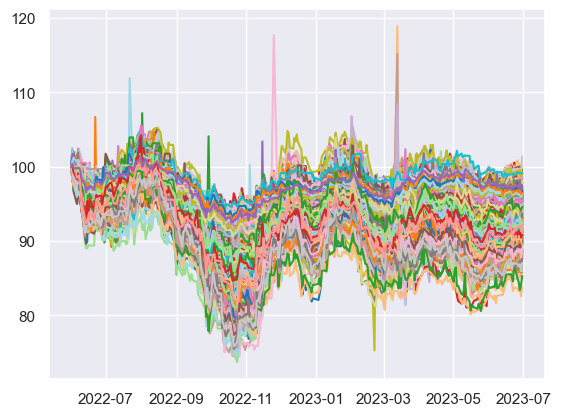

In [114]:
plt.plot(train_prices / train_prices.iloc[0] * 100)
plt.show()

In [115]:
train_returns = df[["Return"]].unstack("cusip").loc[pd.Timestamp("2022-06-01"):]
melted = train_returns.melt()
melted["Direction"] = melted["value"].apply(lambda x: 1 if x > 0 else 0)
len(melted[melted["Direction"] == 1])/ len(melted)

0.4295074859960883

In [12]:
df["Direction"] = df["Return"].apply(lambda x: 1 if x > 0 else 0)
df.head()

Price    Volume  Trades    Return       Age        TTM  \
cusip     trd_dt                                                                
00206RBH4 2018-07-02  86.132 -0.169280    13.0  0.000000  5.041096  24.471233   
          2018-07-03  86.821 -0.779797     7.0  0.007999  5.043836  24.468493   
          2018-07-05  86.730 -0.567504    24.0 -0.001048  5.049315  24.463014   
          2018-07-06  88.675 -0.631757    11.0  0.022426  5.052055  24.460274   
          2018-07-09  89.397 -0.108793     7.0  0.008142  5.060274  24.452055   

                      Stock_Return  Stock_Volume  ETF_Return        PV  \
cusip     trd_dt                                                         
00206RBH4 2018-07-02      0.000000      0.043275    0.000000       NaN   
          2018-07-03      0.015523     -0.171355   -0.005025  0.004849   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749   
          2018-07-06      0.002454      0.232636    0.007858  0.001668   
          2018-07-09      0.004123      0.357721    0.011967 -0.002931   

                           YTM   Duration      DV01   Convexity  Direction  
cusip     trd_dt                                                            
00206RBH4 2018-07-02  0.054010  16.324665 -1.406076  339.273017          0  
          2018-07-03  0.053445  16.343155 -1.418929  339.790490          1  
          2018-07-05  0.053541  16.344714 -1.417577  339.812463          0  
          2018-07-06  0.051959  16.349071 -1.449754  339.925850          1  
          2018-07-09  0.051410  16.326755 -1.459563  339.254704          1

In [251]:
def run_logistic_regression(df, feature, backtest = "False"):

    X = df.drop([feature, "Price", "Return"], axis = 1)[1:].fillna(0)
    Y = df[feature][1:].ffill()

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]

    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, Y_train)
    Y_pred = logistic_model.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    positive_predictions = (sum(Y_pred == 1) / len(Y_pred))

    return accuracy, precision, recall, positive_predictions

In [256]:
run_logistic_regression(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]], 
                   macro_factors], axis = 1), "Direction")

(0.7142857142857143,
 0.746031746031746,
 0.6714285714285714,
 0.46153846153846156)

In [239]:
%%time

logistic_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_logistic_regression(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction")
    logistic_results.loc[len(logistic_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 3min 50s, sys: 13min 51s, total: 17min 42s
Wall time: 1min 39s


In [259]:
logistic_results.sort_values("Accuracy", ascending = True).head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
624,86562MAY6,0.472527,0.37037,0.243902,0.296703
558,718172BD0,0.479853,0.48913,0.321429,0.336996
3,00206RCQ3,0.483516,0.00000,0.000000,0.003663
302,37045VAJ9,0.483516,0.00000,0.000000,0.000000
353,428236BR3,0.483516,0.00000,0.000000,0.000000


In [260]:
logistic_results.drop(["Cusip"], axis = 1).mean(axis = 0)

Accuracy               0.618216
Precision              0.663135
Recall                 0.238564
Positive Prediction    0.164072
dtype: float64

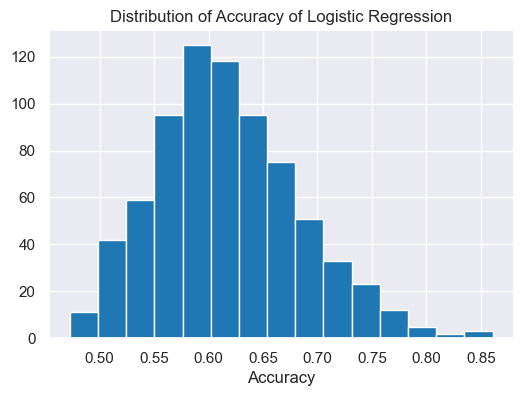

In [249]:
plt.figure(figsize = [6,4])

plt.hist(logistic_results["Accuracy"], bins = 15)
plt.title("Distribution of Accuracy of Logistic Regression")
plt.xlabel("Accuracy")

plt.show()

# Random Forest

In [263]:
def run_random_forest_classifier(df, feature, backtest = "False"):

    X = df.drop([feature, "Price", "Return"], axis = 1)[1:].fillna(0)
    Y = df[feature][1:].ffill()

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]

    rf_model = RandomForestClassifier(n_estimators = 200)
    rf_model.fit(X_train, Y_train)
    Y_pred = rf_model.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    positive_predictions = (sum(Y_pred == 1) / len(Y_pred))

    return accuracy, precision, recall, positive_predictions

In [266]:
run_random_forest_classifier(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]], 
                   macro_factors], axis = 1), "Direction")

(0.7435897435897436,
 0.8414634146341463,
 0.5476190476190477,
 0.30036630036630035)

In [267]:
%%time

rf_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_random_forest_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction")
    rf_results.loc[len(rf_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 4min 11s, sys: 1.52 s, total: 4min 12s
Wall time: 4min 12s


In [269]:
rf_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.717949,0.759259,0.616541,0.395604
1,00206RBK7,0.703297,0.767677,0.567164,0.362637
2,00206RCP5,0.805861,0.813559,0.755906,0.432234
3,00206RCQ3,0.560440,0.833333,0.178571,0.109890
4,00206RCU4,0.765568,0.547945,0.563380,0.267399


In [270]:
rf_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.756227
Precision              0.767082
Recall                 0.619457
Positive Prediction    0.352612
dtype: float64

# Support Vector Machine

In [305]:
def run_svc_classifier(df, feature, kernel = "linear", degree = 0):

    X = df.drop([feature, "Price", "Return"], axis = 1)[1:].fillna(0)
    Y = df[feature][1:].ffill()

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]

    if kernel == "poly":
        svc = SVC(kernel = kernel, degree = degree)
    else:
        svc = SVC(kernel = kernel)
    svc.fit(X_train, Y_train)
    Y_pred = svc.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    positive_predictions = (sum(Y_pred == 1) / len(Y_pred))

    return accuracy, precision, recall, positive_predictions

In [291]:
run_svc_crun_svc_classifier(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]], 
                   macro_factors], axis = 1), "Direction")lassifier(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]], 
                   macro_factors], axis = 1), "Direction")

(0.6373626373626373,
 0.9230769230769231,
 0.2727272727272727,
 0.14285714285714285)

In [295]:
%%time

svc_linear_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_svc_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction")
    svc_linear_results.loc[len(svc_linear_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 1min 25s, sys: 376 ms, total: 1min 26s
Wall time: 1min 26s


In [296]:
svc_linear_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.556777,0.730769,0.142857,0.095238
1,00206RBK7,0.520147,1.000000,0.022388,0.010989
2,00206RCP5,0.593407,0.944444,0.133858,0.065934
3,00206RCQ3,0.490842,0.666667,0.014286,0.010989
4,00206RCU4,0.728938,0.285714,0.028169,0.025641


In [297]:
svc_linear_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.628555
Precision              0.674025
Recall                 0.277636
Positive Prediction    0.189699
dtype: float64

In [311]:
run_svc_classifier(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]], 
                   macro_factors], axis = 1), "Direction", kernel = "poly", degree = 2)

(0.5567765567765568, 0.0, 0.0, 0.0)

In [313]:
%%time

svc_poly2_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_svc_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction", kernel = "poly", degree = 2)
    svc_poly2_results.loc[len(svc_poly2_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 15 s, sys: 210 ms, total: 15.2 s
Wall time: 15.3 s


In [314]:
svc_poly2_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.501832,0.486726,0.413534,0.413919
1,00206RBK7,0.509158,0.000000,0.000000,0.000000
2,00206RCP5,0.465201,0.465201,1.000000,1.000000
3,00206RCQ3,0.487179,0.000000,0.000000,0.000000
4,00206RCU4,0.739927,0.000000,0.000000,0.000000


In [315]:
svc_poly2_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.564812
Precision              0.099754
Recall                 0.097033
Positive Prediction    0.096964
dtype: float64

In [316]:
%%time

svc_poly3_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_svc_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction", kernel = "poly", degree = 3)
    svc_poly3_results.loc[len(svc_poly3_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 15.1 s, sys: 53.5 ms, total: 15.1 s
Wall time: 15.1 s


In [317]:
svc_poly3_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.512821,0.000000,0.0,0.0
1,00206RBK7,0.509158,0.000000,0.0,0.0
2,00206RCP5,0.465201,0.465201,1.0,1.0
3,00206RCQ3,0.487179,0.000000,0.0,0.0
4,00206RCU4,0.739927,0.000000,0.0,0.0


In [318]:
svc_poly3_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.564782
Precision              0.084233
Recall                 0.082524
Positive Prediction    0.082577
dtype: float64

In [319]:
%%time

svc_sigmoid_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_svc_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction", kernel = "sigmoid")
    svc_sigmoid_results.loc[len(svc_sigmoid_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 15.7 s, sys: 62.5 ms, total: 15.7 s
Wall time: 15.7 s


In [320]:
svc_sigmoid_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.487179,0.487179,1.000000,1.000000
1,00206RBK7,0.509158,0.000000,0.000000,0.000000
2,00206RCP5,0.465201,0.464945,0.992126,0.992674
3,00206RCQ3,0.487179,0.000000,0.000000,0.000000
4,00206RCU4,0.395604,0.282407,0.859155,0.791209


In [321]:
svc_sigmoid_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.497274
Precision              0.311238
Recall                 0.499748
Positive Prediction    0.500012
dtype: float64

In [322]:
%%time

svc_rbf_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_svc_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction", kernel = "rbf")
    svc_rbf_results.loc[len(svc_rbf_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 19 s, sys: 87.8 ms, total: 19.1 s
Wall time: 19.1 s


In [323]:
svc_rbf_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.516484,0.666667,0.015038,0.010989
1,00206RBK7,0.509158,0.000000,0.000000,0.000000
2,00206RCP5,0.465201,0.465201,1.000000,1.000000
3,00206RCQ3,0.487179,0.000000,0.000000,0.000000
4,00206RCU4,0.739927,0.000000,0.000000,0.000000


In [324]:
svc_rbf_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.567149
Precision              0.218609
Recall                 0.069509
Positive Prediction    0.068785
dtype: float64

In [341]:
compare_error_SVC = pd.DataFrame(columns = ["Accuracy", "Precision", "Recall", "Positive Prediction"])
compare_error_SVC.loc["Linear"] = np.mean(svc_linear_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error_SVC.loc["Poly (Degree = 2)"] = np.mean(svc_poly2_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error_SVC.loc["Poly (Degree = 3)"] = np.mean(svc_poly3_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error_SVC.loc["Sigmoid"] = np.mean(svc_sigmoid_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error_SVC.loc["Radial Basis"] = np.mean(svc_rbf_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error_SVC = compare_error_SVC.rename(columns = {"R2 Test": "Test R2"})
compare_error_SVC

,Accuracy,Precision,Recall,Positive Prediction
Linear,0.628555,0.674025,0.277636,0.189699
Poly (Degree = 2),0.564812,0.099754,0.097033,0.096964
Poly (Degree = 3),0.564782,0.084233,0.082524,0.082577
Sigmoid,0.497274,0.311238,0.499748,0.500012
Radial Basis,0.567149,0.218609,0.069509,0.068785


# Naive Bayes

In [350]:
def run_gnb_classifier(df, feature):

    X = df.drop([feature, "Price", "Return"], axis = 1)[1:].fillna(0)
    Y = df[feature].iloc[1:].ffill()

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]
    
    gnb = GaussianNB()
    gnb.fit(X_train, Y_train)
    Y_pred = gnb.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    positive_predictions = (sum(Y_pred == 1) / len(Y_pred))

    return accuracy, precision, recall, positive_predictions

In [362]:
run_gnb_classifier(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]], 
                   macro_factors], axis = 1), "Direction")

(0.6410256410256411, 0.3984375, 0.7083333333333334, 0.46886446886446886)

In [363]:
%%time

gnb_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_gnb_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction")
    gnb_results.loc[len(gnb_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 2.89 s, sys: 95.1 ms, total: 2.99 s
Wall time: 2.99 s


In [364]:
gnb_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.725275,0.688312,0.796992,0.564103
1,00206RBK7,0.699634,0.666667,0.776119,0.571429
2,00206RCP5,0.758242,0.719424,0.787402,0.509158
3,00206RCQ3,0.710623,0.680473,0.821429,0.619048
4,00206RCU4,0.622711,0.359649,0.577465,0.417582


In [365]:
gnb_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.677631
Precision              0.642852
Recall                 0.681031
Positive Prediction    0.487488
dtype: float64

# Compare Methods

In [367]:
compare_error = pd.DataFrame(columns = ["Accuracy", "Precision", "Recall", "Positive Prediction"])
compare_error.loc["Logistic Regression"] = np.mean(logistic_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error.loc["Linear SVC"] = np.mean(rf_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error.loc["Random Forest"] = np.mean(svc_linear_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error.loc["Naive Bayes"] = np.mean(gnb_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error.T

,Logistic Regression,Linear SVC,Random Forest,Naive Bayes
Accuracy,0.618216,0.756227,0.628555,0.677631
Precision,0.663135,0.767082,0.674025,0.642852
Recall,0.238564,0.619457,0.277636,0.681031
Positive Prediction,0.164072,0.352612,0.189699,0.487488
